# Preparation

## Loading the packages

In [ ]:
import numpy as np

## Create Directorys

In [ ]:
!mkdir './csv'

## Set random seed

In [ ]:
np.random.seed(5329)

## Datasets

In [ ]:
# put dataset on colab ssd
%cd /content/
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# download rgb dataset
link = '1o9JXIOXJ1Q7tjzdcXL8BHVQA8bF69nY6'  # share link of file

downloaded = drive.CreateFile({'id':link}) 
downloaded.GetContentFile('Assignment1-Dataset.zip')

!unzip Assignment1-Dataset.zip -d /content/

/content
Archive:  Assignment1-Dataset.zip
   creating: /content/Assignment1-Dataset/
  inflating: /content/__MACOSX/._Assignment1-Dataset  
  inflating: /content/Assignment1-Dataset/test_label.npy  
  inflating: /content/__MACOSX/Assignment1-Dataset/._test_label.npy  
  inflating: /content/Assignment1-Dataset/train_data.npy  
  inflating: /content/__MACOSX/Assignment1-Dataset/._train_data.npy  
  inflating: /content/Assignment1-Dataset/train_label.npy  
  inflating: /content/__MACOSX/Assignment1-Dataset/._train_label.npy  
  inflating: /content/Assignment1-Dataset/test_data.npy  
  inflating: /content/__MACOSX/Assignment1-Dataset/._test_data.npy  


In [ ]:
train_data = np.load("/content/Assignment1-Dataset/train_data.npy")
train_label = np.load("/content/Assignment1-Dataset/train_label.npy")
test_data = np.load("/content/Assignment1-Dataset/test_data.npy")
test_label = np.load("/content/Assignment1-Dataset/test_label.npy")

## Preprocessing

In [ ]:
class Standardisation(object):
    def fit_transform(self, data):
        self.mean = np.mean(data)
        self.std = np.std(data)
        return (data - data.mean(axis=0, keepdims=True)) / data.std(axis=0, keepdims=True)

    def transform(self, data):
        return (data - data.mean(axis=0, keepdims=True)) / data.std(axis=0, keepdims=True)

    def fit(self, data):
        self.mean = np.mean(data)
        self.std = np.std(data)
        return self
# # Standardisation normalizer
# standard_transformer = Standardisation()
# data_train = standard_transformer.fit_transform(train_data)
# data_test = standard_transformer.transform(test_data)

In [ ]:
class MinMax_transformer:
    def fit_transform(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        return (data - self.min) / (self.max - self.min)

    def transform(self, data):
        return (data - self.min) / (self.max - self.min)

    def fit(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        return self


# # min_max normalizer
# min_max_transformer = MinMax_transformer()
# data_train = min_max_transformer.fit_transform(train_data)
# data_test = min_max_transformer.transform(test_data)

# Method

## Overview

In this work, we implement following modules:


1.   A more than one hidden layer MLP
2.   ReLU activation & Leaky ReLU activation
3.   Weight decay
4.   Momentum in SGD & RMSProp
5.   Dropout
6.   Softmax and cross-entropy loss
7.   Mini-batch training
8.   Batch Normalization



### Model Architecture

As shown in the following figure, our model includes several **Hidden** Layers, one **Output** Layer and one **Loss** Layer(SoftMax + CrossEntropy Layer in this case). 

In each Hidden Layer, there are four embedding inner layers which are **FC**(Fully Connected) Layer, **BN**(Batch Normalisation) Layer, **Dropout** Layer and **ReLU** layer. The application of BN layer and Dropout layer are controlled by the input parameters when define the model class.

The Output Layer take as input the output of last Hidden Layer and linear mapping to neurons of the number of classes.

The result of Output Layer is then processed by Loss Layer to calculate the loss.

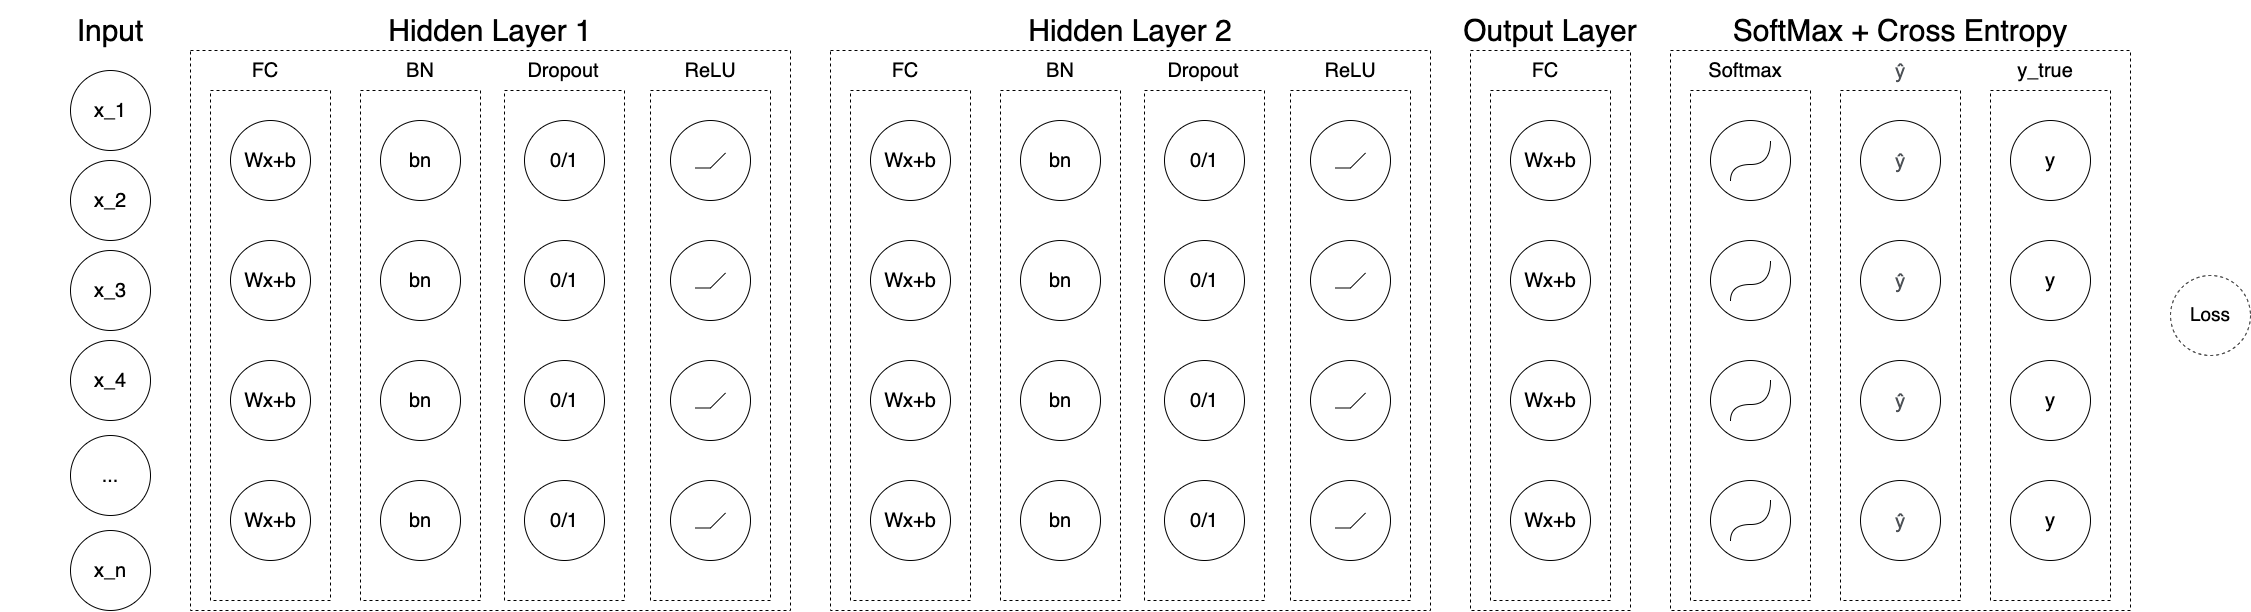

### Code Architecture

In general, we implement our method in a Object-oriented programming(OOP) way. Four classes are implemented, which are class `MLP`, class `HiddenLayer`, `Optimiser` class `CrossEntropy`. The detail methods and functions are shown below.

Three `Optimiser` is implemented, which are **SGD**, **SGD_momentum** and **RMSProp**. Details about the methods and functions are shown in the following figure.

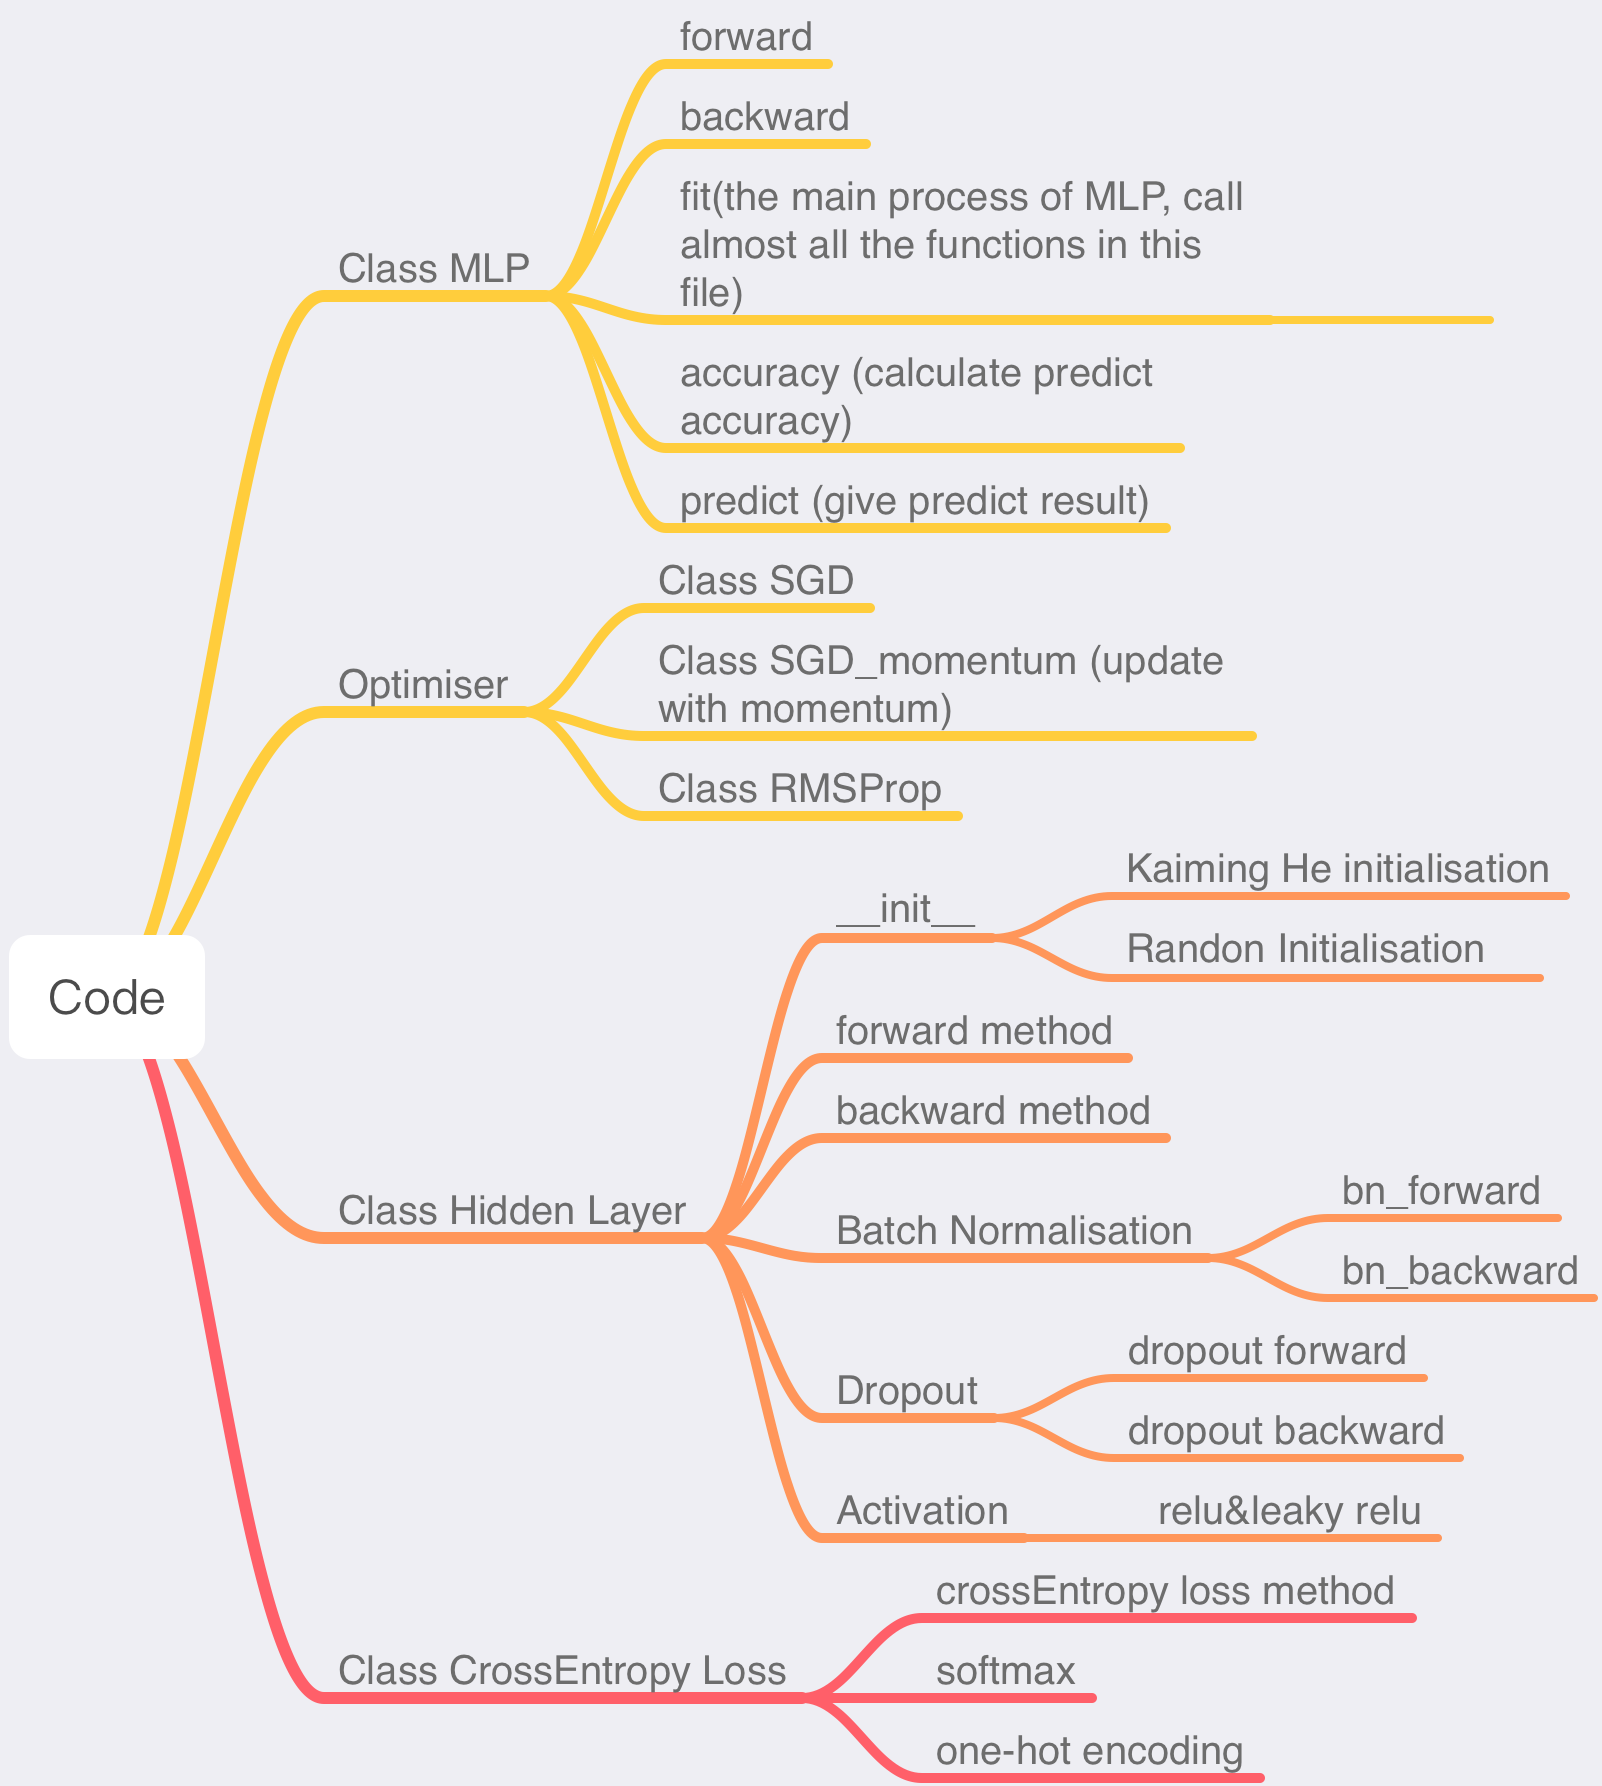

## MLP Class

In [ ]:
"""
Class MLP implements a Multiple Layer Perceptron.
"""
class MLP:
    def __init__(self, n_neurons=[128, 256, 10], activation=[None, 'relu', 'relu'], dropout=0.2, bn=True):
        """
        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden layer

        :type dropout: int
        :param dropout: The rate to dropout neurons, for example, if dropout=0.2, 20% neurons in the model are disabled

        :type bn: bool
        :param bn: The flag to turn on or turn off batch normalisation layer
        """
        self.bn = bn
        self.n_neurons = n_neurons
        self.dropout = dropout
        self.activation = activation

        # default training mode
        self.mode = 'train'
        self.layers = []
        for i in range(len(n_neurons) - 1):
            # add layers
            self.layers.append(HiddenLayer(n_in=n_neurons[i], # input size
                                         n_out=n_neurons[i + 1], # output size
                                         activation=self.activation[i + 1], # the inner activation layer of this layer
                                         layer_index=i, # layer index
                                         bn=self.bn, # batch normalisation switch
                                         dropout=self.dropout, # dropout rate
                                         output_layer=(i == len(n_neurons) - 2)) # flag of output_layer
                               )


    def train(self):
        """
        switch mode to training        
        """
        self.mode = 'train'

    def eval(self):
        """
        switch mode to evaluation        
        """
        self.mode = 'eval'

    def forward(self, input):
        """
        layer by layer forward propagation

        :type input: ndarray
        :param input: dataset
        """
        for layer in self.layers:
            output = layer.forward(input, self.mode)
            input = output
        return output

    def backward(self, delta):
        """
        layer by layer back propagation

        :type delta: ndarray
        :param delta: the derivative of output layer
        """
        for layer in reversed(self.layers):
            delta = layer.backward(delta)

    def accuracy(self, y, y_hat):
        """
        calculate the prediction accuracy

        :type y: ndarray
        :param y: the true labels

        :type y_hat: ndarray
        :param y_hat: the output of the output layer
        """
        y_pred = np.argmax(y_hat, axis=1).reshape(y.shape)
        accuracy = np.equal(y, y_pred).sum() / y.shape[0]
        return accuracy

    def predict(self, X):
        """
        layer by layer back propagation

        :type X: ndarray
        :param X: the input dataset
        """
        y_hat = self.forward(X)
        y_pred = np.argmax(y_hat, axis=1)
        return y_pred

    def fit(self, X, y, batch_size=16, learning_rate=0.1, epochs=100, data_val="data_test", label_val="label_test", momentum = 0.9, weight_decay = 0):
        """
        layer by layer back propagation

        :type X: ndarray
        :param X: dataset

        :type y: ndarray
        :param y: corresponding labels

        :type batch_size: int
        :param batch_size: the size mini-batch for mini-batch training

        :type learning_rate: float
        :param learning_rate: the rate to update parameters

        :type epochs: int
        :param epochs: model will go through the whole dataset epochs times

        :type data_val: ndarray
        :param data_val: the dataset to be evaluate

        :type label_val: ndarray
        :param label_val: the corresponding evaluation labels
        """

        # print training parameters
        print("**" * 50)
        print("Model layers: {}".format(self.n_neurons))
        print("Model activation functions: {}".format(self.activation))
        print("Batch size: {}".format(batch_size))
        print("Total epoch: {}".format(epochs))
        print("Learning rate: {}".format(learning_rate))
        print("Dropout: {}".format(self.dropout))
        print("Batch Norm: {}".format(self.bn))
        print("Momentum: {}".format(momentum))
        print("Weight decay: {}".format(weight_decay))
        print("**" * 50)
        
        # strat training
        self.train()
        for epoch in range(epochs):
            # shuffle the training set to make each epoch's batch different
            shuffle = np.arange(X.shape[0])
            np.random.shuffle(shuffle)
            X_train = X[shuffle]
            y_train = y[shuffle]

            loss_sum = 0  # the loss summation for this epoch
            for batch_start_ind in range(0, X_train.shape[0], batch_size):
                # prepare mini-batch
                X_batch = X_train[batch_start_ind: min(batch_start_ind + batch_size, X_train.shape[0])]
                y_batch = y_train[batch_start_ind: min(batch_start_ind + batch_size, X_train.shape[0])]

                # forward pass
                y_hat = self.forward(X_batch)

                # calculate loss and the derivative of output layer
                loss, delta = CrossEntropy().criterion_CrossEntropy(y_batch, y_hat)
                # backward pass
                self.backward(delta)

                # update with SGD_Momentum
                optim = SGD_Momentum()
                optim.step(self, learning_rate, momentum=momentum, weight_decay=weight_decay)

                # Epoch loss sum
                loss_sum += loss.sum()

            # start evaluation
            self.eval()
            y_hat_train = self.forward(X_train)
            y_hat_val = self.forward(data_val)
            self.training_acc = self.accuracy(y_train, y_hat_train)
            self.val_acc = self.accuracy(label_val, y_hat_val)
            loss_val, _ = CrossEntropy().criterion_CrossEntropy(label_val, y_hat_val)

            # print evaluation result
            print(
                'Epoch ({}/{}): Train Loss: {}  Train Accuracy: {}  Validation Loss: {}  Validation Accuracy: {}'.format(
                    epoch + 1,
                    epochs,
                    loss_sum,
                    self.training_acc,
                    loss_val,
                    self.val_acc))
        return self

## Optimiser Class

In [ ]:
class RMSProp:
    def step(self, model, lr, rho=0.999, epsi=10e-05):
        """
        layer by layer back propagation

        :type model: MLP
        :param model: the model to be updated

        :type lr: float
        :param lr: the rate to update parameters

        :type rho: int
        :param rho: the size mini-batch for mini-batch training

        :type epsi: float
        :param epsi: the rate to update parameters
        """
        for layer in model.layers:
            layer.r_w = rho * layer.r_w + (1 - rho) * layer.grad_W * layer.grad_W
            # update weight
            layer.W = layer.W - (lr / (np.sqrt(layer.r_w) + epsi) * layer.grad_W)
            
            # weight decay
            weight_decay: float = 0.00005
            layer.W = layer.W - layer.W * weight_decay

            layer.r_b = rho * layer.r_b + (1 - rho) * layer.grad_b * layer.grad_b
            
            # update bias
            layer.b = layer.b - (lr / (np.sqrt(layer.r_b) + epsi) * layer.grad_b)

            layer.grad_W = np.zeros_like(layer.grad_W)
            layer.grad_b = np.zeros_like(layer.grad_b)

            # update BN param
            if layer.bn and not layer.isOutputLayer:
                layer.bn_param['gamma'] = layer.bn_param['gamma'] - lr * layer.bn_param['dgamma']
                layer.bn_param['beta'] = layer.bn_param['beta'] - lr * layer.bn_param['dbeta']

class SGD_Momentum:
    def step(self, model, lr, momentum=0.9, weight_decay=0):
        for layer in model.layers:
            # update momentum paramters
            layer.V_w = momentum * layer.V_w + lr * layer.grad_W
            layer.V_b = momentum * layer.V_b + lr * layer.grad_b
            
            # update Weight
            layer.W = layer.W - layer.V_w
      
            # weight decay
            layer.W = layer.W - lr * layer.W * weight_decay

            # update Bias
            layer.b = layer.b - layer.V_b

            # update BN param
            if layer.bn and not layer.isOutputLayer:
                layer.bn_param['gamma'] = layer.bn_param['gamma'] - lr * layer.bn_param['dgamma']
                layer.bn_param['beta'] = layer.bn_param['beta'] - lr * layer.bn_param['dbeta']

## Hidden Layer Class

In [ ]:
class HiddenLayer(object):
    """
    sub modules in MLP
    """
    def __init__(self, n_in, n_out, layer_index, activation=None, bn=True, dropout=0.2,
                 output_layer=False):
        self.isOutputLayer = output_layer
        self.name = "Hidden layer " + str(layer_index + 1) if not self.isOutputLayer else "Output layer"
        self.input = None
        self.n_in = n_in  # number of neurons in current layer
        self.n_out = n_out  # number of neurons in next layer
        self.activation_name = activation
        self.bn = bn
        self.dropout = dropout

        # initialize parameters: kaiming init
        self.W = np.random.normal(
            loc=0,
            scale=2 / self.n_in,
            size=(self.n_in, self.n_out)
        )
        self.b = np.zeros(shape=(self.n_out,))

        # we set he size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

        # momentum parameters
        self.V_w = np.zeros(self.W.shape)
        self.V_b = np.zeros(self.b.shape)

        # rmsprop parameters
        self.r_w = np.zeros(self.W.shape)    # initialise r for w and b
        self.r_b = np.zeros(self.b.shape)

        # batch normalization init
        self.bn_cache = {}
        self.bn_eval = {"running_mean": np.zeros(n_out),
                        "running_var": np.zeros(n_out)}
        self.bn_param = {
            "eps": 1e-5,
            "momentum": 0.9,
            "gamma": np.ones(self.n_out, ),
            "beta": np.zeros(self.n_out, )
        }

    """
    Hidden Layer forward propagation
    """

    def forward(self, input, mode):
        # update self parameters
        self.mode = mode
        self.input_batch_size = input.shape[0]
        self.input = input
        # update self parameters

        # forward process
        # fc forward
        self.lin_output = self.input @ self.W + self.b
        # output layer has no bn and dropout layer
        if self.isOutputLayer:
            self.activation_output = self.activation_forward(self.lin_output)
            return self.activation_output
        # bn forward
        self.bn_output = self.bn_forward(self.lin_output)
        # dropout forward
        self.dropout_output = self.dropout_forward(self.bn_output)
        # activation forward
        self.activation_output = self.activation_forward(self.dropout_output)
        return self.activation_output

    """
    Hidden Layer backward propagation
    """

    def backward(self, delta):
        # output layer has no bn and dropout layer
        if not self.isOutputLayer:
            delta = self.activation_backward(delta)
            delta = self.dropout_backward(delta)
            delta = self.bn_backward(delta)

        # calculate grad
        grad_W_all = []
        for i in range(self.input_batch_size):
            grad_W_all.append(np.atleast_2d(self.input[i]).T.dot(np.atleast_2d(delta[i])))
        grad_W_all = np.stack(grad_W_all, axis=0)

        # set grad_W to 0
        self.grad_W = np.mean(grad_W_all, axis=0)
        self.grad_b = np.mean(delta, axis=0)

        # calculate the derivative for last layer
        delta = delta.dot(self.W.T)
        return delta


    """
    batch normalization functions
    """

    # forward functions
    def bn_forward(self, input):
        if self.bn:
            eps = self.bn_param["eps"]
            momentum = self.bn_param['momentum']
            if self.mode == 'train':
                batch_mean = np.mean(input, axis=0)
                batch_var = np.var(input, axis=0)

                # Estimate running average of mean and variance to use at test time
                self.bn_eval['running_mean'] = momentum * self.bn_eval['running_mean'] + (1 - momentum) * batch_mean
                self.bn_eval['running_var'] = momentum * self.bn_eval['running_var'] + (1 - momentum) * batch_var

                # Normalization followed by Affine transformation
                input_norm = (input - batch_mean) / np.sqrt(batch_var + eps)
                output = self.bn_param["gamma"] * input_norm + self.bn_param["beta"]

                # Cache variables needed during backpropagation
                self.bn_cache["input"] = input
                self.bn_cache["input_norm"] = input_norm
                self.bn_cache["batch_mean"] = batch_mean
                self.bn_cache["batch_var"] = batch_var
                self.bn_cache["gamma"] = self.bn_param["gamma"]
                self.bn_cache["beta"] = self.bn_param["beta"]
                self.bn_cache["eps"] = self.bn_param['eps']

            elif self.mode == 'eval':
                # normalize using running average
                input_norm = (input - self.bn_eval["running_mean"]) / np.sqrt(self.bn_eval["running_var"] + eps)
                output = self.bn_param["gamma"] * input_norm + self.bn_param["beta"]
            return output

        else:
            return input

    # backward functions
    def bn_backward(self, delta):
        if self.bn:
            # unpack parameters
            input_norm = self.bn_cache["input_norm"]
            batch_var = self.bn_cache["batch_var"]
            eps = self.bn_cache["eps"]
            input = self.bn_cache["input"]
            batch_mean = self.bn_cache["batch_mean"]
            gamma = self.bn_cache["gamma"]

            # See derivations above for dgamma, dbeta and dx
            self.bn_param["dgamma"] = np.sum(delta * input_norm, axis=0)
            self.bn_param["dbeta"] = np.sum(delta, axis=0)
            
            m = input.shape[0]
            t = 1. / np.sqrt(batch_var + eps)

            # calculate the derivations
            delta = (gamma * t / m) * (m * delta - np.sum(delta, axis=0)
                                       - t ** 2 * (input - batch_mean)
                                       * np.sum(delta * (input - batch_mean), axis=0))

        return delta

    """
    activation layer functions
    """

    def activation_forward(self, input):
        if self.activation_name == 'tanh':
            return np.tanh(input)
        elif self.activation_name == 'relu':
            return np.maximum(0, input)
        elif self.activation_name == 'leaky_relu':
            return np.where(input >= 0, input, 0.01*input)
        else:
            return input

    def activation_backward(self, delta):
        if self.activation_name == 'tanh':
            return delta * (1 - np.square(self.activation_output))
        elif self.activation_name == 'relu':
            return delta * np.where(self.dropout_output >= 0, 1, 0)
        elif self.activation_name == 'leaky_relu':
            return delta * np.where(self.dropout_output >= 0, 1, 0.01)
        else:
            return delta

    """
    dropout layer functions
    """

    def dropout_forward(self, input):
        if self.dropout:
            keep_rate = 1 - self.dropout
            # create a 0/1 mask 
            self.mask = np.random.binomial(1, keep_rate, size=input.shape) / keep_rate
            output = input * self.mask
            return output
        else:
            return input

    def dropout_backward(self, delta):
        if self.dropout:
            return delta * self.mask
        else:
            return delta


## CrossEntropy Class

In [ ]:
class CrossEntropy(object):
    """
    CrossEntropy Loss functions
    """
    def __init__(self):
        self.name = "CrossEntropy Loss layer"

    def criterion_CrossEntropy(self, y, y_hat):
        """
        CrossEntropy Loss functions
        """
        n_class = y_hat.shape[-1]
        y_hat_prob = self.softmax(y_hat)
        y_one_hot = np.array(self.oneHotEncoding(y, n_class))
        eps = np.finfo(float).eps  # in case of infinite log
        loss = -np.sum(y_one_hot * np.log(y_hat_prob + eps))
        delta = y_hat_prob - y_one_hot
        return loss, delta

    def oneHotEncoding(self, data, n_class):
        """
        transform to oneHotEncoding
        """
        onehot = np.zeros((data.shape[0], n_class))
        for i in range(data.shape[0]):
            k = int(data[i])
            onehot[i, k] = int(1)
        return onehot.squeeze()  # len(y) * 10 features


    def softmax(self, data):
        """
        calculate softmax logits
        """
        output = []
        for i in range(0, data.shape[0]):
            equ = np.exp(data[i]) / np.exp(data[i]).sum()
            output.append(equ)
        return np.vstack(output)

# Train and evaluation

## define model

In [ ]:
# number of classes
n_class = np.unique(train_label).shape[0]
# number of features
n_features = train_data.shape[1]
# define a MLP mode
nn = MLP([n_features, 256, 128, n_class],
             [None, 'leaky_relu','leaky_relu', None],
             dropout=0,
             bn=False)

## train & evaluate

In [ ]:
data_train = train_data
data_test = test_data
label_train = train_label
label_test = test_label

# strat training
model = nn.fit(data_train,
               label_train,
               learning_rate=0.001,
               epochs=48,
               batch_size=2,
               data_val=data_test,
               label_val=label_test,
               momentum=0,
               weight_decay=0.001)

****************************************************************************************************
Model layers: [128, 256, 128, 10]
Model activation functions: [None, 'leaky_relu', 'leaky_relu', None]
Batch size: 2
Total epoch: 48
Learning rate: 0.001
Dropout: 0
Batch Norm: False
****************************************************************************************************
Epoch (1/48): Train Loss: 111435.56738168365  Train Accuracy: 0.24368  Validation Loss: 20447.983274531514  Validation Accuracy: 0.254
Epoch (2/48): Train Loss: 96404.89921337675  Train Accuracy: 0.32838  Validation Loss: 18240.700507279988  Validation Accuracy: 0.329
Epoch (3/48): Train Loss: 88042.37134060037  Train Accuracy: 0.39294  Validation Loss: 16782.23329251402  Validation Accuracy: 0.3959
Epoch (4/48): Train Loss: 81938.4198798742  Train Accuracy: 0.434  Validation Loss: 15834.500713992193  Validation Accuracy: 0.4319
Epoch (5/48): Train Loss: 77677.73016863887  Train Accuracy: 0.46018  Validation

Model AUC: 0.35786855555555563
Model F1 socre: 0.5691456385243153
Model Accuracy socre: 0.5693


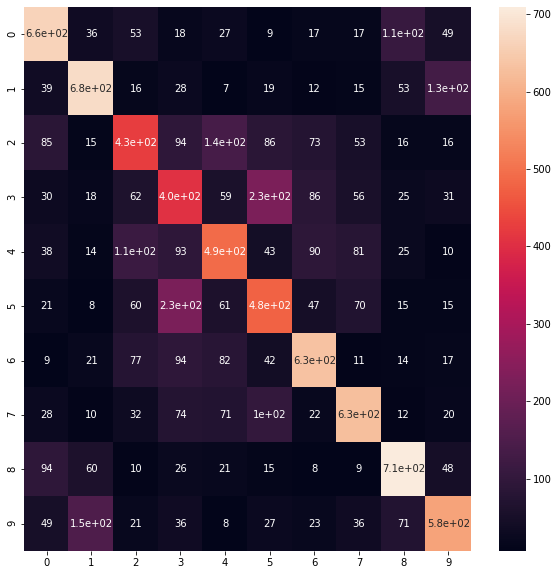

In [ ]:
# modules for evaluation
from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
model.eval()
y_pred = model.predict(data_test)
fpr, tpr, thresholds = metrics.roc_curve(label_test, y_pred, pos_label=2)
auc = metrics.auc(fpr, tpr)
f1_score = metrics.f1_score(label_test, y_pred, average='macro')
acc = metrics.accuracy_score(label_test, y_pred)

print("Model AUC: {}".format(auc))
print("Model F1 socre: {}".format(f1_score))
print("Model Accuracy socre: {}".format(acc))

cm = metrics.confusion_matrix(label_test, y_pred)
df_cm = pd.DataFrame(cm, index=[i for i in range(10)],
                     columns=[i for i in range(10)])
plt.figure(figsize=(10, 10))
sn.heatmap(df_cm, annot=True)
plt.show()